# DengAI: Predicting Disease Spread

***

## Hypothesis
- Because dengue fever is a tropical disease, we would expect it to be more popular in place with high temperature, high precipitation and thus high humidity.
- The disease is transmitted by mosquitoes, whose peak season is summer, so we will expect summer to have more dengue cases than the rest of the year.
- Iquitos is a Peruvian port city and gateway to the jungle lodges and tribal villages of the northern Amazon. Surrounded by green spaces and water sources, it is an ideal environment for mosquitoes. San juan, in the other hand, is a city on an island (more isolated) and has a much lower population density than Iquitos. All these informations suggest that we will need 2 separate models, one for each city.

***

## Data reading

In [1]:
# -*- coding: utf-8 -*-
import re
import time
import operator
import numpy as np
import pandas as pd 
import collections
import unicodedata
import collections
import seaborn as sns
import collections
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt

from tqdm import tqdm
from collections import Counter
from datetime import datetime, date, timedelta
from IPython.display import Image


%matplotlib inline

pylab.rcParams['figure.figsize'] = 13,10

plt.style.use('bmh')
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', 
          '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

In [127]:
feature = pd.read_csv('data/dengue_features_train.csv', infer_datetime_format=True)
label = pd.read_csv('data/dengue_labels_train.csv')

In [128]:
feature.shape

(1456, 24)

The dataset contains information on 1456 weeks for the 2 cities across 24 features.

In [129]:
feature.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


In [5]:
label.head()

,city,year,weekofyear,total_cases
0,sj,1990,18,4
1,sj,1990,19,5
2,sj,1990,20,4
3,sj,1990,21,3
4,sj,1990,22,6


Let's fusion the 2 dataframes:

In [6]:
df = pd.merge(feature, label, how='outer', on=label.columns.tolist()[:-1])

In [7]:
df.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


Check duplicate rows:

In [8]:
np.sum(df.duplicated())

0

Check NA:

In [9]:
np.sum(df.isnull(),axis=0)

city                                       0
year                                       0
weekofyear                                 0
week_start_date                            0
ndvi_ne                                  194
ndvi_nw                                   52
ndvi_se                                   22
ndvi_sw                                   22
precipitation_amt_mm                      13
reanalysis_air_temp_k                     10
reanalysis_avg_temp_k                     10
reanalysis_dew_point_temp_k               10
reanalysis_max_air_temp_k                 10
reanalysis_min_air_temp_k                 10
reanalysis_precip_amt_kg_per_m2           10
reanalysis_relative_humidity_percent      10
reanalysis_sat_precip_amt_mm              13
reanalysis_specific_humidity_g_per_kg     10
reanalysis_tdtr_k                         10
station_avg_temp_c                        43
station_diur_temp_rng_c                   43
station_max_temp_c                        20
station_mi

We drop all rows having less than 20 non-NA features

In [10]:
df = df.dropna(axis=0, thresh=20)

In [11]:
df.shape

(1446, 25)

In [12]:
np.sum(df.isnull(),axis=0)

city                                       0
year                                       0
weekofyear                                 0
week_start_date                            0
ndvi_ne                                  189
ndvi_nw                                   47
ndvi_se                                   17
ndvi_sw                                   17
precipitation_amt_mm                       3
reanalysis_air_temp_k                      0
reanalysis_avg_temp_k                      0
reanalysis_dew_point_temp_k                0
reanalysis_max_air_temp_k                  0
reanalysis_min_air_temp_k                  0
reanalysis_precip_amt_kg_per_m2            0
reanalysis_relative_humidity_percent       0
reanalysis_sat_precip_amt_mm               3
reanalysis_specific_humidity_g_per_kg      0
reanalysis_tdtr_k                          0
station_avg_temp_c                        33
station_diur_temp_rng_c                   33
station_max_temp_c                        10
station_mi

Check the sanity of the "city" column

In [13]:
df.city.value_counts()

sj    930
iq    516
Name: city, dtype: int64

***

# EDA

In [119]:
df_sj = df_mean[df_mean.city == 'sj'].copy()
df_iq = df_mean[df_mean.city == 'iq'].copy()

test_sj = test[test.city == 'sj'].copy()
test_iq = test[test.city == 'iq'].copy()

In [14]:
df.columns.tolist()

['city',
 'year',
 'weekofyear',
 'week_start_date',
 'ndvi_ne',
 'ndvi_nw',
 'ndvi_se',
 'ndvi_sw',
 'precipitation_amt_mm',
 'reanalysis_air_temp_k',
 'reanalysis_avg_temp_k',
 'reanalysis_dew_point_temp_k',
 'reanalysis_max_air_temp_k',
 'reanalysis_min_air_temp_k',
 'reanalysis_precip_amt_kg_per_m2',
 'reanalysis_relative_humidity_percent',
 'reanalysis_sat_precip_amt_mm',
 'reanalysis_specific_humidity_g_per_kg',
 'reanalysis_tdtr_k',
 'station_avg_temp_c',
 'station_diur_temp_rng_c',
 'station_max_temp_c',
 'station_min_temp_c',
 'station_precip_mm',
 'total_cases']

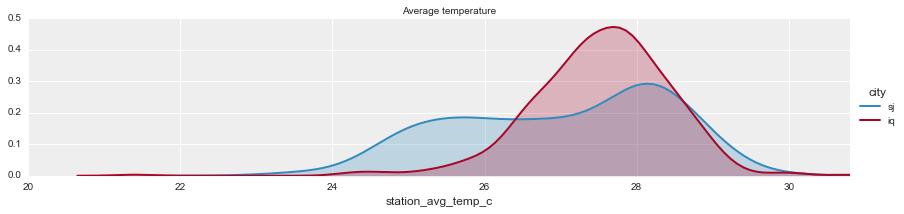

In [15]:
fig = sns.FacetGrid(df, hue='city', aspect=4) 
fig.map(sns.kdeplot,'station_avg_temp_c',shade=True)
max_x = df.station_avg_temp_c.max()
fig.set(xlim=(20,max_x))
fig.add_legend()
fig.fig.suptitle("Average temperature")

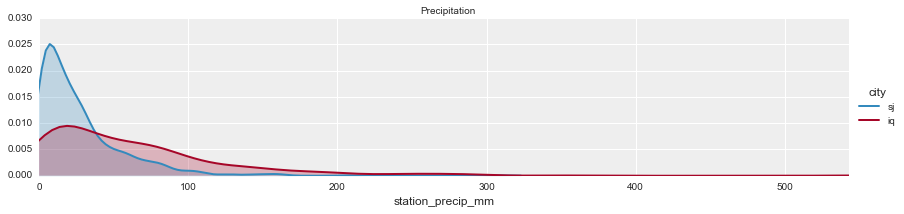

In [16]:
fig = sns.FacetGrid(df, hue='city', aspect=4) 
fig.map(sns.kdeplot,'station_precip_mm',shade=True)
max_x = df.station_precip_mm.max()
min_x = df.station_precip_mm.min()
fig.set(xlim=(0,max_x))
fig.add_legend()
fig.fig.suptitle("Precipitation")

Concerning the climate factors, we can say that Iquitos is generally a littlbe bit hotter than San Juan, and the precipitation is much higher. 

If what our hypothesis is true, the number of dengue cases in Iquitos must be higher than that of San juan.

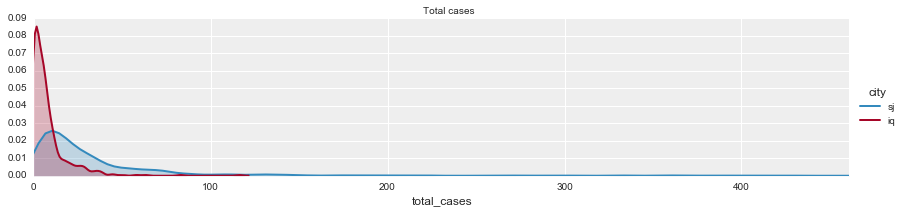

In [17]:
fig = sns.FacetGrid(df, hue='city', aspect=4) 
fig.map(sns.kdeplot,'total_cases',shade=True)
max_x = df.total_cases.max()
min_x = df.total_cases.min()
fig.set(xlim=(min_x,max_x))
fig.add_legend()
fig.fig.suptitle("Total cases")

In [18]:
df.groupby('city').mean().total_cases

city
iq     7.596899
sj    34.122581
Name: total_cases, dtype: float64

Surprisingly, San Juan has a lot more dengue cases than Iquitos 

Now let's check the evolution of dengue disease through time

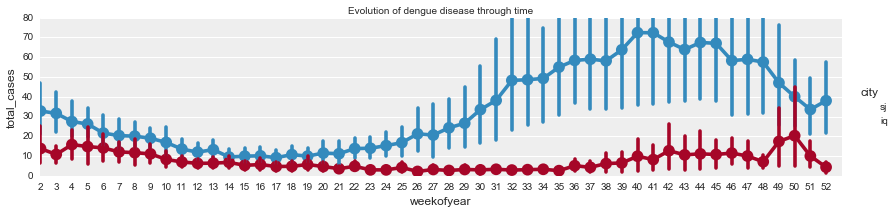

In [19]:
fig = sns.FacetGrid(df, hue='city', aspect=4) 
fig.map(sns.pointplot,'weekofyear','total_cases')
max_x = df.weekofyear.max()
min_x = df.weekofyear.min()
fig.set(xlim=(min_x,max_x))
fig.set(ylim=(0, 80))
fig.add_legend()
fig.fig.suptitle("Evolution of dengue disease through time")

In San Juan, one clear trend is that the dengue virus becomes a lot more active at the other half of the year, starting from July (week 28).

In Iquitos, the disease develop much slower, with its peak at the very end of the year (week 50).

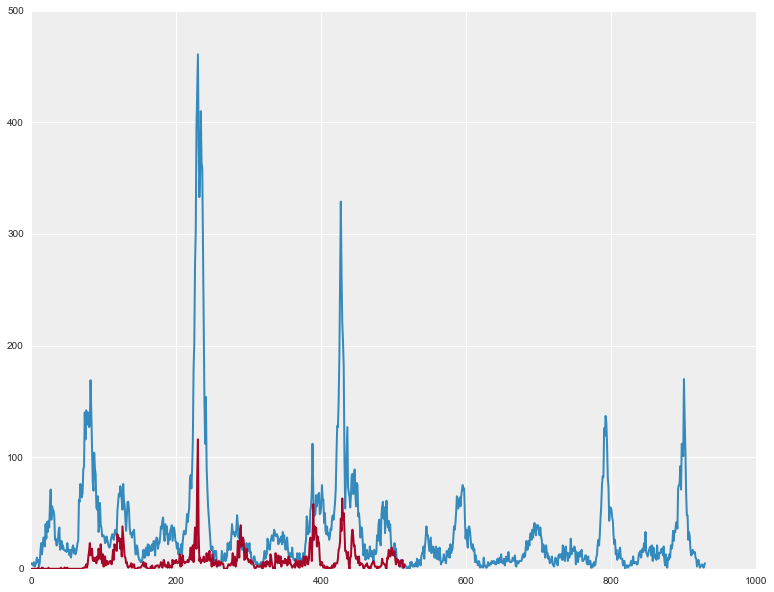

In [140]:
plt.plot(range(len(df_sj)), df_sj.total_cases.values)
plt.plot(range(len(df_iq)), df_iq.total_cases.values)

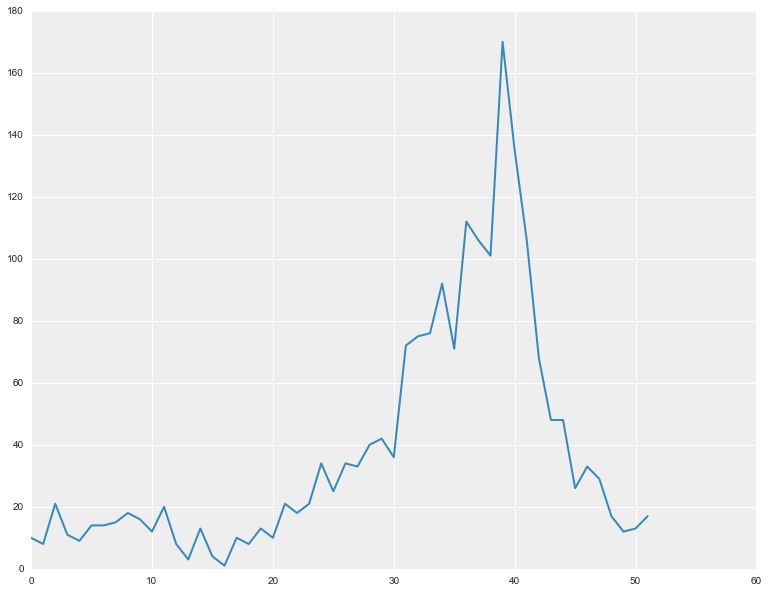

In [144]:
plt.plot(range(len(df_sj[df_sj.year==2007])), df_sj[df_sj.year==2007].total_cases.values)

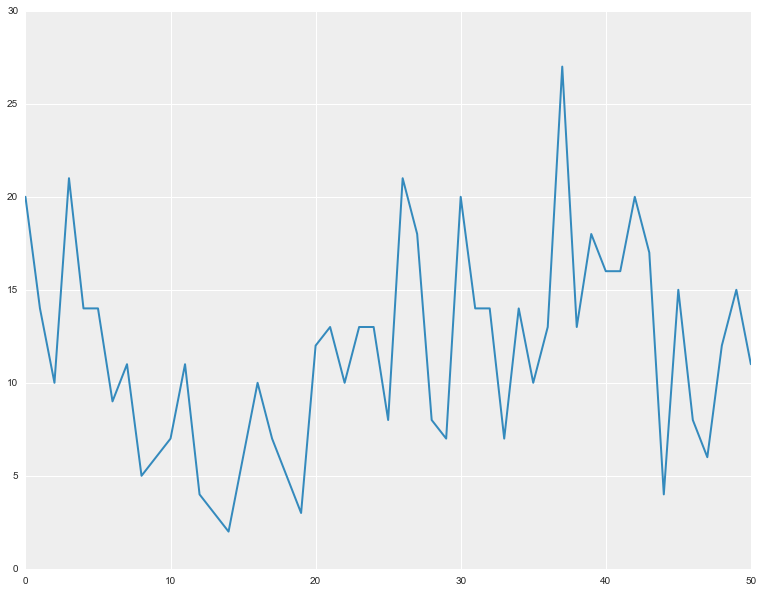

In [147]:
plt.plot(range(len(df_sj[df_sj.year==2004])), df_sj[df_sj.year==2004].total_cases.values)

# Baseline model

In [20]:
from sklearn import cross_validation, metrics
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

/Users/admin/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [21]:
def modelfit(alg, dtrain, predictors, target, n_fold=10):
    alg.fit(dtrain[predictors], dtrain[target])
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_prediction = np.round(dtrain_predictions)
    
    cv_mae_score = cross_val_score(alg, dtrain[predictors], dtrain[target], cv=n_fold, scoring='neg_mean_absolute_error') 
    cv_mae_score = np.abs(cv_mae_score)
  
    
    #Print model report:
    print "\nModel Report: {0}-fold cross-validation".format(n_fold)
    #print "RMSE : %.4g" % np.sqrt(metrics.mean_squared_error(dtrain[target].values, dtrain_predictions))

    print "Mean absolute error on training set: %.4g" % metrics.mean_absolute_error(dtrain[target].values, dtrain_predictions)
    print "Mean - %.4g | Median - %.4g | Std - %.4g | Min - %.4g | Max - %.4g" % (np.mean(cv_mae_score),
                                                                                  np.median(cv_mae_score),
                                                                                  np.std(cv_mae_score),
                                                                                  np.min(cv_mae_score), 
                                                                                  np.max(cv_mae_score))
    

def baseline_test(test_df, predictors, target, plotting=False, num_feature=10): 
    
#     base_result = test_df[target][:]
#     base_result[:] = base_result.mean(axis=0)
#     print "NAIVE MODEL: all predictions = mean value" 
#     print "Mean absolute error : %.4g" % np.sqrt(metrics.mean_squared_error(test_df[target].values, base_result))
#     print "----------------------------------------"
    
#     lm = LinearRegression(normalize=False)
#     print "LINEAR REGRESSION" 
#     modelfit(lm, test_df, predictors, target)
#     coef1 = pd.Series(lm.coef_, predictors).sort_values()
#     if plotting: 
#         coef1.plot(kind='barh', title='Model Coefficcients')
#         plt.show()
#     print "----------------------------------------"

    lasso = Lasso(alpha = .01, normalize=True)
    print "LASSO REGRESSION"
    modelfit(lasso, test_df, predictors, target)
    coef1 = pd.Series(lasso.coef_, predictors).sort_values()
    if plotting: 
        coef1.plot(kind='barh', title='Model Coefficcients')
        plt.show()
    print "----------------------------------------"

    print "RANDOM FOREST"
    rf = RandomForestRegressor(n_estimators=200, n_jobs=-1)
    modelfit(rf, test_df, predictors, target)
    rf.fit(test_df[predictors], test_df[target])
    rf.feature_importances_
#     sorted_features =  sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), predictors), 
#                  reverse=True)
    sorted_features = pd.Series(rf.feature_importances_, predictors).sort_values(ascending=False)

#     for x,y in sorted_features: 
#         print y,x 

    if plotting: 
        print "FEATURES SORTED BY THEIR SCORE:\n"
        sorted_features[::-1].plot(kind='barh')
        
    #print "----------------------------------------"

    return sorted_features[:num_feature].index.tolist() # return top 10 features

We will encode the "city" feature

In [22]:
df = df.join(pd.get_dummies(df.city))

In [23]:
df.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases,iq,sj
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4,0.0,1.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5,0.0,1.0
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4,0.0,1.0
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3,0.0,1.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6,0.0,1.0


We create the list of predictors

In [24]:
np.sum(df.isnull(), axis=0)

city                                       0
year                                       0
weekofyear                                 0
week_start_date                            0
ndvi_ne                                  189
ndvi_nw                                   47
ndvi_se                                   17
ndvi_sw                                   17
precipitation_amt_mm                       3
reanalysis_air_temp_k                      0
reanalysis_avg_temp_k                      0
reanalysis_dew_point_temp_k                0
reanalysis_max_air_temp_k                  0
reanalysis_min_air_temp_k                  0
reanalysis_precip_amt_kg_per_m2            0
reanalysis_relative_humidity_percent       0
reanalysis_sat_precip_amt_mm               3
reanalysis_specific_humidity_g_per_kg      0
reanalysis_tdtr_k                          0
station_avg_temp_c                        33
station_diur_temp_rng_c                   33
station_max_temp_c                        10
station_mi

In [25]:
ignore_feature_list = ['city', 'ndvi_ne', 'week_start_date', 'total_cases']

In [26]:
predictors = [feature for feature in df.columns.tolist() if feature not in ignore_feature_list]
target = 'total_cases'

For the remaining feature with nan values, for now we will just fill the nan values with their mean

In [27]:
df_mean = df.fillna(df.mean())

Ok let's run the baseline models

LASSO REGRESSION

Model Report: 10-fold cross-validation
Mean absolute error on training set: 20.02
Mean - 21.25 | Median - 19.39 | Std - 10.72 | Min - 7.408 | Max - 46.73


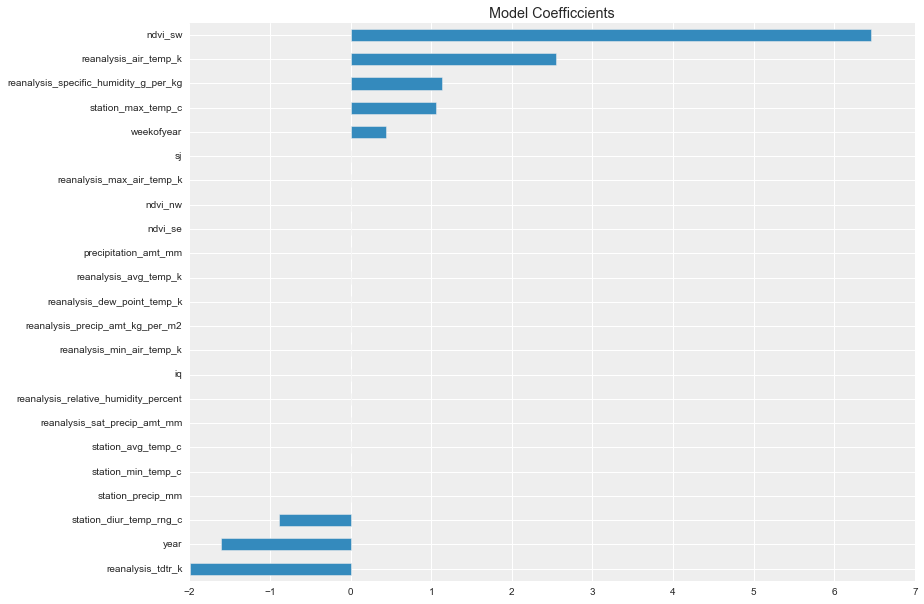

----------------------------------------
RANDOM FOREST

Model Report: 10-fold cross-validation
Mean absolute error on training set: 4.506
Mean - 19.92 | Median - 17.61 | Std - 12.47 | Min - 6.841 | Max - 47.54
FEATURES SORTED BY THEIR SCORE:



['year',
 'weekofyear',
 'ndvi_nw',
 'ndvi_sw',
 'reanalysis_air_temp_k',
 'station_precip_mm',
 'ndvi_se',
 'station_max_temp_c',
 'reanalysis_precip_amt_kg_per_m2',
 'reanalysis_dew_point_temp_k']

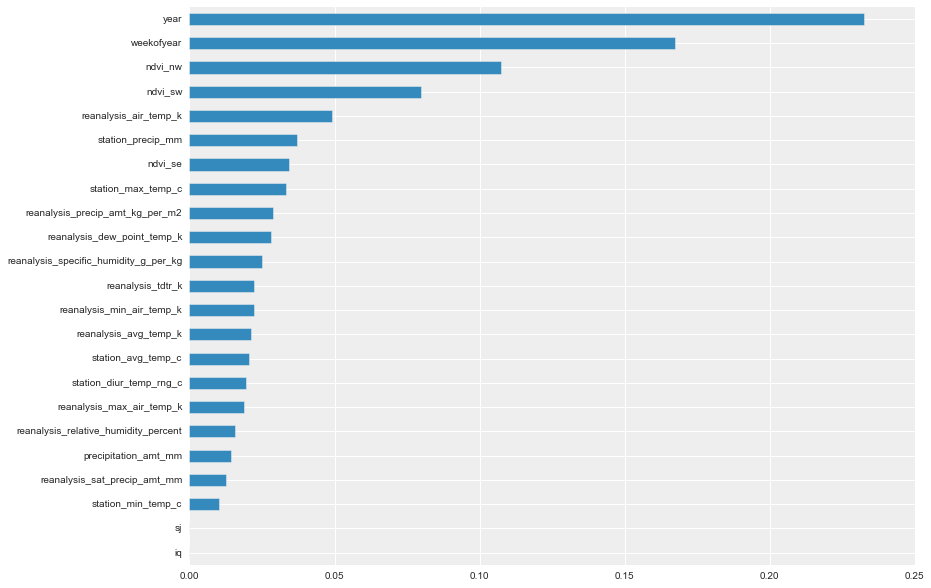

In [28]:
baseline_test(df_mean, predictors, target, plotting=True)

***

## First submission

In [29]:
test = pd.read_csv('data/dengue_features_test.csv')

In [30]:
#test = test.fillna(df.mean())

In [31]:
test = test.join(pd.get_dummies(test.city))

In [32]:
def make_prediction(alg, train_df, test_df, predictors, target):

    alg.fit(train_df[predictors], train_df[target])
    predictions = alg.predict(test_df[predictors])
    
    result_df = test_df[['city', 'year', 'weekofyear']].copy()
    result_df['total_cases'] = predictions
    result_df.total_cases = result_df.total_cases.round()
    result_df.total_cases = result_df.total_cases.astype(int)
    
    return result_df

In [33]:
rf = RandomForestRegressor(n_estimators=300, n_jobs=-1)
result = make_prediction(rf, df, test, predictors, target)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [ ]:
result.to_csv('submission.csv', index=False)

This model gave a leaderboard error of 26,3173.

***

# Separated models

We will build 1 model for each city

In [ ]:
df_mean.city.value_counts()

In [ ]:
baseline_test(df_sj, predictors[:-2], target) # omit the 2 dummy predictors about city
print '***********************************************************'
baseline_test(df_iq, predictors[:-2], target)

The model works well with Iquitos but not San Juan

In [ ]:
rf = RandomForestRegressor(n_estimators=300, n_jobs=-1)

result_sj = make_prediction(rf, df_sj, test_sj, predictors[:-2], target)
result_iq =  make_prediction(rf, df_iq, test_iq, predictors[:-2], target)

result = pd.concat([result_sj, result_iq])

result.to_csv('submission.csv', index=False)

This model gave an error rate of 26.1466 on the leaderboard, a slight improvement.

Wee can see that the model of San Juan doesn't work very well, so for now we will concentrate on it.

***

## Gaussian Process

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels \
    import RBF, WhiteKernel, RationalQuadratic, ExpSineSquared

from sklearn.model_selection import KFold

import GPy

There are different implementations of Gaussian Process in Python, 2 of which are **sklearn** and **GPy**. The sklearn's implementation obviously has an advantage because it shares the same api with other function that we use, but **GPy** seems to be prefered by researchers and have a lot more options. 

We will test them on our dataset with cross-validation.

In [ ]:
kf = KFold(n_splits=10)

sk_error_list = []
gpy_error_list = []

sk_time = []
gpy_time = []

for train_index, test_index in kf.split(df_sj):
    
    X_train, X_test = df_sj[predictors[:-2]].iloc[train_index].values, df_sj[predictors[:-2]].iloc[test_index].values
    y_train, y_test = df_sj[target].iloc[train_index].values.reshape(-1,1), df_sj[target].iloc[test_index].values.reshape(-1,1)
    
    # gaussian process of sklearn
    t0 = time.clock()
    
    rbf_kernel = RBF()
    gp = GaussianProcessRegressor(kernel=rbf_kernel, n_restarts_optimizer=10, normalize_y=True)
    gp.fit(X_train, y_train)
    gp_prediction = np.round(gp.predict(X_test))
    sk_error = metrics.mean_absolute_error(gp_prediction, y_test)
    sk_error_list.append(sk_error)
    
    sk_time.append(time.clock() - t0)
    
    # gaussian process of GPy
    t0 = time.clock()
    
    kernel = GPy.kern.RBF(input_dim=len(predictors[:-2]), variance=1., lengthscale=1.)
    m_sj = GPy.models.GPRegression(X_train, y_train, kernel)
    m_sj.optimize(messages=False)
    mean_sj, sigma_sj = m_sj.predict(X_test)
    mean_sj = np.round(mean_sj)
    gpy_error = metrics.mean_absolute_error(mean_sj, y_test)
    gpy_error_list.append(gpy_error)
    
    gpy_time.append(time.clock() - t0)

    
print "Sklearn GP: mean {0:.2f} - std {1:.2f} - processing time {2} s".format(np.mean(sk_error_list), np.std(sk_error_list), np.mean(sk_time))
print "GPy GP: mean {0:.2f} - std {1:.2f} - processing time {2} s".format(np.mean(gpy_error_list), np.std(gpy_error_list), np.mean(gpy_time))

We see that the 2 implementations give quite the same results, but GPy takes a lot more time. 

From now on, we will work with the sklearn GP.

Let's try a simple additive kernel to capture the short-term and long-term trend in our data.

In [ ]:
additive_rbf_kernel = RBF(1) + RBF(10)
gp = GaussianProcessRegressor(kernel=additive_rbf_kernel, n_restarts_optimizer=10, normalize_y=True)

modelfit(gp, df_sj, predictors[:-2], target)

In [ ]:
additive_rbf_kernel = RBF(1) 
gp = GaussianProcessRegressor(kernel=additive_rbf_kernel, n_restarts_optimizer=10, normalize_y=True)

modelfit(gp, df_sj, predictors[:-2], target)

In [ ]:
additive_rbf_kernel = RBF(1) + RBF(10) + WhiteKernel()
gp = GaussianProcessRegressor(kernel=additive_rbf_kernel, n_restarts_optimizer=10, normalize_y=True)

modelfit(gp, df_sj, predictors[:-2], target)

In [ ]:
additive_rbf_kernel = RBF(1) + RationalQuadratic() + WhiteKernel()
gp = GaussianProcessRegressor(kernel=additive_rbf_kernel, n_restarts_optimizer=10, normalize_y=True)

modelfit(gp, df_sj, predictors[:-2], target)

The simple 2 rbf model seems to be the best. Let's make a submission:

In [ ]:
additive_rbf_kernel = RBF(1) + RBF(10)
gp = GaussianProcessRegressor(kernel=additive_rbf_kernel, n_restarts_optimizer=10, normalize_y=True)


result_sj = make_prediction(gp, df_sj, test_sj, predictors[:-2], target)
result_iq =  make_prediction(gp, df_iq, test_iq, predictors[:-2], target)

result = pd.concat([result_sj, result_iq])

result.to_csv('submission.csv', index=False)

The result is a little better than the original model with 1 RBF, but still inferior than the Random Forest approach.

# Model diagnostic

Plotting the learning curve is usually a good idea to see what the problem is.

In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='neg_mean_absolute_error')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [ ]:
%%time

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

X = df_sj[predictors[:-2]]
y = df_sj[target]

# title = "Learning Curves (Gaussian Process)"
title = "Learning Curves (Random Forest)"

# Cross validation with 20 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
#cv = ShuffleSplit(n_splits=20, test_size=0.2, random_state=0)

#rbf_kernel = RBF()
#gp = GaussianProcessRegressor(kernel=rbf_kernel, n_restarts_optimizer=10, normalize_y=True)
rf = RandomForestRegressor(n_estimators=300, n_jobs=-1)
plot_learning_curve(rf, title, X, y, cv=10, n_jobs=-1)

plt.show()

## Improvement

First, we will examine the data imputation step. Before, we use mean imputation, however in case of time serie data, a forward fill imputation might be more appropriate. 

We will create a processing function to make sure that we don't forget any steps. We will complete this function as we go.

In [38]:
def processing_function(df):
    
    df.fillna(method='ffill', inplace=True)
    
    df_sj = df.loc[df.city == 'sj']
    df_iq = df.loc[df.city == 'iq']
    
    return df_sj, df_iq
    

In [39]:
sj, iq = processing_function(df)
test_sj, test_iq = processing_function(test)

In [109]:
top10_feature_sj = baseline_test(sj, predictors[:-2], target) # omit the 2 dummy predictors about city
print '***********************************************************'
top10_feature_iq = baseline_test(iq, predictors[:-2], target)

LASSO REGRESSION

Model Report: 10-fold cross-validation
Mean absolute error on training set: 27.11
Mean - 30.1 | Median - 23.83 | Std - 13.7 | Min - 17.89 | Max - 64.03
----------------------------------------
RANDOM FOREST

Model Report: 10-fold cross-validation
Mean absolute error on training set: 4.982
Mean - 29.97 | Median - 25.38 | Std - 16.83 | Min - 8.726 | Max - 65.01
***********************************************************
LASSO REGRESSION

Model Report: 10-fold cross-validation
Mean absolute error on training set: 6.336
Mean - 7.128 | Median - 7.113 | Std - 1.703 | Min - 4.783 | Max - 9.834
----------------------------------------
RANDOM FOREST

Model Report: 10-fold cross-validation
Mean absolute error on training set: 1.959
Mean - 7.809 | Median - 7.983 | Std - 1.059 | Min - 5.195 | Max - 9.185


In [74]:
top5_feature_sj = baseline_test(sj, predictors[:-2], target, num_feature=5) 
print '***********************************************************'
top5_feature_iq = baseline_test(iq, predictors[:-2], target, num_feature=5)

LASSO REGRESSION

Model Report: 10-fold cross-validation
Mean absolute error on training set: 26.98
Mean - 30.58 | Median - 24.12 | Std - 14.22 | Min - 18.54 | Max - 66.27
----------------------------------------
RANDOM FOREST

Model Report: 10-fold cross-validation
Mean absolute error on training set: 4.865
Mean - 29.73 | Median - 25.2 | Std - 16.66 | Min - 8.629 | Max - 64.75
***********************************************************
LASSO REGRESSION

Model Report: 10-fold cross-validation
Mean absolute error on training set: 6.257
Mean - 7.299 | Median - 7.238 | Std - 1.787 | Min - 4.937 | Max - 9.934
----------------------------------------
RANDOM FOREST

Model Report: 10-fold cross-validation
Mean absolute error on training set: 1.976
Mean - 7.818 | Median - 8.072 | Std - 1.074 | Min - 5.089 | Max - 9.035


In [84]:
_ = baseline_test(sj, top10_feature_sj, target) 
print '***********************************************************'
_ = baseline_test(iq, top10_feature_iq, target)

LASSO REGRESSION

Model Report: 10-fold cross-validation
Mean absolute error on training set: 27.54
Mean - 30.11 | Median - 23.73 | Std - 13.77 | Min - 17.54 | Max - 64.23
----------------------------------------
RANDOM FOREST

Model Report: 10-fold cross-validation
Mean absolute error on training set: 4.519
Mean - 29.61 | Median - 24.48 | Std - 16.44 | Min - 9.796 | Max - 64.7
***********************************************************
LASSO REGRESSION

Model Report: 10-fold cross-validation
Mean absolute error on training set: 6.356
Mean - 7.061 | Median - 7.044 | Std - 1.754 | Min - 4.751 | Max - 9.915
----------------------------------------
RANDOM FOREST

Model Report: 10-fold cross-validation
Mean absolute error on training set: 1.828
Mean - 7.821 | Median - 8.019 | Std - 1.119 | Min - 5.389 | Max - 9.283


In [85]:
_ = baseline_test(sj, top5_feature_sj, target) 
print '***********************************************************'
_ = baseline_test(iq, top5_feature_iq, target)

LASSO REGRESSION

Model Report: 10-fold cross-validation
Mean absolute error on training set: 27.63
Mean - 30.01 | Median - 23.74 | Std - 13.53 | Min - 18.05 | Max - 63.83
----------------------------------------
RANDOM FOREST

Model Report: 10-fold cross-validation
Mean absolute error on training set: 3.845
Mean - 29.75 | Median - 23.85 | Std - 16.21 | Min - 10.43 | Max - 64.22
***********************************************************
LASSO REGRESSION

Model Report: 10-fold cross-validation
Mean absolute error on training set: 6.324
Mean - 6.989 | Median - 7.109 | Std - 1.763 | Min - 4.592 | Max - 9.666
----------------------------------------
RANDOM FOREST

Model Report: 10-fold cross-validation
Mean absolute error on training set: 1.652
Mean - 7.518 | Median - 8.025 | Std - 1.285 | Min - 4.899 | Max - 9.29


In [77]:
top5_feature_iq

['year',
 'weekofyear',
 'station_precip_mm',
 'station_avg_temp_c',
 'reanalysis_specific_humidity_g_per_kg']

Ok it seems that with the best model is the one with 5 features. Let's make a submssion.

In [ ]:
rf = RandomForestRegressor(n_estimators=300, n_jobs=-1)

result_sj = make_prediction(rf, sj, test_sj, top5_feature_sj, target)
result_iq =  make_prediction(rf, iq, test_iq, top5_feature_iq, target)

result = pd.concat([result_sj, result_iq])

result.to_csv('submission.csv', index=False)

27.545, Not good at all, we will try with 10 features.

In [86]:
lasso = Lasso(alpha = .01, normalize=False)
rf = RandomForestRegressor(n_estimators=300, n_jobs=-1)

result_sj = make_prediction(rf, sj, test_sj, top10_feature_sj, target)
result_iq =  make_prediction(lasso, iq, test_iq, top10_feature_iq, target)

result = pd.concat([result_sj, result_iq])

result.to_csv('submission.csv', index=False)

In [216]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return np.hstack((ret[:n-1],ret[n - 1:] / n))

In [230]:
def general_rolling_cross_validation(df_sj, df_iq, alg_sj, alg_iq, predictors_sj, predictors_iq, target='total_cases', time_step=4):
    
    fold_size_sj = df_sj.shape[0]/time_step
    fold_size_iq = df_iq.shape[0]/time_step
    
    error_list = []
    
    for i in xrange(time_step-1):
        
        train_sj = df_sj.iloc[: (i+1)*fold_size_sj]
        test_sj = df_sj.iloc[(i+1)*fold_size_sj: (i+2)*fold_size_sj]
        
        train_iq = df_iq.iloc[: (i+1)*fold_size_iq]
        test_iq = df_iq.iloc[(i+1)*fold_size_iq: (i+2)*fold_size_iq]
                    
        alg_sj.fit(train_sj[predictors_sj], train_sj[target])
        predictions_sj = alg_sj.predict(test_sj[predictors_sj])
        
        alg_iq.fit(train_iq[predictors_iq], train_iq[target])
        predictions_iq = alg_iq.predict(test_iq[predictors_iq])
        
        predictions = np.hstack((predictions_sj, predictions_iq))
        predictions = moving_average(predictions, n=3)

        true_values = np.hstack((test_sj[target], test_iq[target]))
        
        error = metrics.mean_absolute_error(np.round(predictions), true_values)
#         error = metrics.mean_absolute_error(predictions, true_values)
        
        error_list.append(error)
        
    
    print "Rolling cross-validation: ", 
    print "Mean {0:.2f} - Median {1:.2f} - Std {2:.2f}".format(np.mean(error_list), np.median(error_list), np.std(error_list))
    
    return error_list
        

In [224]:
def rolling_cross_validation(df, alg, predictors, target='total_cases', time_step=4):
    
    fold_size = df.shape[0]/time_step
    
    error_list = []
    
    for i in xrange(time_step-1):
        
        train = df.iloc[: (i+1)*fold_size]
        test = df.iloc[(i+1)*fold_size: (i+2)*fold_size]
                            
        alg.fit(train[predictors], train[target])
        predictions = alg.predict(test[predictors])        
     
        predictions = moving_average(predictions, n=5)
        
        error = metrics.mean_absolute_error(np.round(predictions), test[target])
        
        error_list.append(error)
        
    
    #print "Rolling cross-validation: ", 
    #print "Mean {0:.2f} - Median {1:.2f} - Std {2:.2f}".format(np.mean(error_list), np.median(error_list), np.std(error_list))
    
    return np.mean(error_list), predictions
        

In [87]:
from hyperopt import hp, fmin, tpe, hp, STATUS_OK, Trials

best_score = np.inf

def hyperopt_train_test(params):
    
    rf = RandomForestRegressor(**params)
    
    return rolling_cross_validation(sj, rf, predictors[:-2])
    
    
def score(params):
    
    global best_score    
        
    params = {feature: int(value) for feature, val in params.items() if type(val)=='float'}
    
    score = hyperopt_train_test(params)
    
    if score < best_score: 
        print "Searching...", 
        print "New best score: {0}".format(score)
        best_score = score

    return {'loss': score, 'status': STATUS_OK}
    
def optimize(trials):
        
    space = {
             'max_depth': hp.quniform('max_depth', 0, 30, 1),
             'max_features': hp.quniform('max_features', 0, len(predictors[:-2]), 1),
             'n_estimators': hp.qnormal('n_estimators', 500, 200, 1),
             'min_samples_split': hp.quniform('min_samples_split', 1, 100, 1),
             'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 10, 1)
             }

    best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=500)

    print "Done."
    print "Best parameter setting:", best

In [88]:
trials = Trials()
optimize(trials)

Searching... New best score: 53.2514367816
Searching... New best score: 48.9497126437
Searching... New best score: 48.2672413793
Searching... New best score: 47.8218390805
Searching... New best score: 45.5359195402
Searching... New best score: 43.1336206897
Searching... New best score: 42.8663793103
Searching... New best score: 40.5316091954
Done.
Best parameter setting: {'max_features': 12.0, 'min_samples_split': 88.0, 'n_estimators': 674.0, 'max_depth': 18.0, 'min_samples_leaf': 3.0}


In [98]:
from hyperopt import hp, fmin, tpe, hp, STATUS_OK, Trials

best_score = np.inf

def hyperopt_train_test(params):
    
    rf = RandomForestRegressor(**params)
    
    return rolling_cross_validation(iq, rf, predictors[:-2])
    
    
def score(params):
    
    global best_score    
    
    params = {feature: int(value) for feature, val in params.items() if type(val)=='float'}

    
    score = hyperopt_train_test(params)
    
    if score < best_score: 
        print "Searching...", 
        print "New best score: {0}".format(score)
        best_score = score

    return {'loss': score, 'status': STATUS_OK}
    
def optimize(trials):
        
    space = {
             'max_depth': hp.quniform('max_depth', 0, 30, 1),
             'max_features': hp.quniform('max_features', 0, len(predictors[:-2]), 1),
             'n_estimators': hp.qnormal('n_estimators', 500, 200, 1),
             'min_samples_split': hp.quniform('min_samples_split', 1, 100, 1),
             'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 10, 1)
             }

    best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=100)

    print "Done."
    print "Best parameter setting:", best

In [99]:
trials_iq = Trials()
optimize(trials_iq)

Searching... New best score: 9.11369509044
Searching... New best score: 9.04909560724
Searching... New best score: 8.96640826873
Searching... New best score: 8.88372093023
Searching... New best score: 8.4677002584
Searching... New best score: 8.33074935401
Done.
Best parameter setting: {'max_features': 10.0, 'min_samples_split': 19.0, 'n_estimators': 200.0, 'max_depth': 16.0, 'min_samples_leaf': 5.0}


In [112]:
rf_sj = RandomForestRegressor(max_features=10, 
                              min_samples_split=88, 
                              n_estimators=674,
                              max_depth=18,
                              min_samples_leaf=3)

rf_iq = RandomForestRegressor(max_features=10, 
                              min_samples_split=19, 
                              n_estimators=200,
                              max_depth=16,
                              min_samples_leaf=5)

In [115]:
_ = general_rolling_cross_validation(sj, iq, rf_sj, rf_iq, predictors[:-2], predictors[:-2])

Rolling cross-validation:  Mean 25.63 - Median 28.44 - Std 6.84


In [107]:
result_sj = make_prediction(rf_sj, sj, test_sj, predictors[:-2], target)
result_iq =  make_prediction(rf_iq, iq, test_iq, predictors[:-2], target)

result = pd.concat([result_sj, result_iq])

result.to_csv('submission.csv', index=False)

This gave us 25.8 on LB, the best result so far. The result is quite close to our CV error, which is great!

Let's see if we can improve it using only the top 10 features

In [113]:
_ = general_rolling_cross_validation(sj, iq, rf_sj, rf_iq, top10_feature_sj, top10_feature_iq)

Rolling cross-validation:  Mean 28.27 - Median 28.04 - Std 9.24


Not very good, but I think we will need to recompute the top 10 feature with the correct cv function above.

Now we will add the lagging feature.

In [163]:
def processing_function(df):
    
    df.fillna(method='ffill', inplace=True)
    
#     df['lagged_1'] = df.total_cases.shift(1)
#     df['lagged_2'] = df.total_cases.shift(2)

#     df.lagged_1 = df.lagged_1.fillna(0)
#     df.lagged_2 = df.lagged_2.fillna(0)
    
    df_sj = df.loc[df.city == 'sj']
    df_iq = df.loc[df.city == 'iq']
    
    return df_sj, df_iq
    

In [164]:
sj, iq = processing_function(df)
test_sj, test_iq = processing_function(test)

In [231]:
_ = general_rolling_cross_validation(sj, iq, rf_sj, rf_iq, predictors[:-2], predictors[:-2])

Rolling cross-validation:  Mean 25.54 - Median 28.26 - Std 6.97


In [251]:
result_sj = make_prediction(rf_sj, sj, test_sj, predictors[:-2], target)
result_iq =  make_prediction(rf_iq, iq, test_iq, predictors[:-2], target)

result = pd.concat([result_sj, result_iq])

first_2_cases = result.loc[:1, 'total_cases'].values

result.total_cases = result.total_cases.rolling(window=3).mean()

result.loc[:1,'total_cases'] = first_2_cases

result.total_cases = result.total_cases.astype(int)

result.to_csv('submission.csv', index=False)

In [252]:
result.head()

,city,year,weekofyear,total_cases
0,sj,2008,18,7
1,sj,2008,19,22
2,sj,2008,20,12
3,sj,2008,21,14
4,sj,2008,22,14


New best LB score: 25.0801 !